<a href="https://colab.research.google.com/github/hendradarwin/covid-19-prediction/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %tensorflow_version 2.x # make sure that collab use tensorflow 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/virgiawan/covid-19-prediction/master/dataset/global_total.csv \
    -O /tmp/global_total.csv

time_trimmed shape =  (65,)
series_trimmed shape =  (65,)


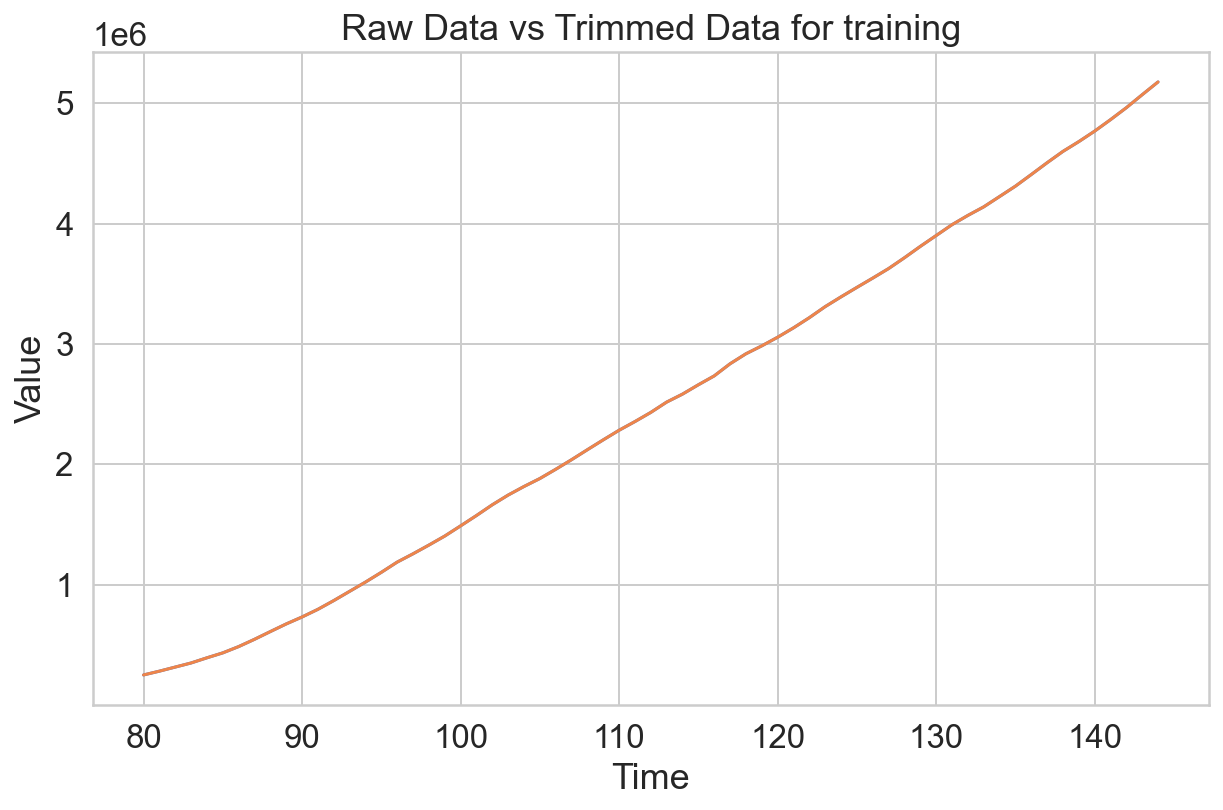

In [3]:
import csv
time_step = []
temps = []


# with open('/tmp/global_total.csv') as csvfile:
with open('D:\\total_cases.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)

series_trimmed = series[80:]
time_trimmed = time[80:]

series = series_trimmed
time = time_trimmed

split_time = 50



plt.figure(figsize=(10, 6))
plt.title("Raw Data vs Trimmed Data for training")
plot_series(time, series)
plot_series(time_trimmed, series_trimmed)

print("time_trimmed shape = ", time_trimmed.shape)
print("series_trimmed shape = ", series_trimmed.shape)


In [4]:
time_train = time_trimmed[:split_time]
x_train = series_trimmed[:split_time]
time_valid = time_trimmed[split_time:]
x_valid = series_trimmed[split_time:]

window_size = 3
batch_size = 2
shuffle_buffer_size = 10

# print("time_train=", time_train)
# print("x_train=",x_train)



In [5]:
# ini buat yg pake DNN
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
# ini buat yg pake RNN
def windowed_dataset_rnn(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(2).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
tf.keras.backend.clear_session()

window_size = 3
batch_size = 3
shuffle_buffer_size = 20

# DNN
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([  
  tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

# RNN
# train_set = windowed_dataset_rnn(x_train, window_size, batch_size, shuffle_buffer_size)
# model = tf.keras.models.Sequential([  
#   tf.keras.layers.Conv1D(filters=7, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),  
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64, return_sequences=True),                      
#   tf.keras.layers.Dense(80, input_shape=[window_size], activation="relu"),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 6000000)
# ])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-9 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500) # , callbacks=[lr_schedule]


547
Epoch 312/500
16/16 [==============================] - 0s 2ms/step - loss: 34470.9219 - mae: 34123.7344
Epoch 313/500
16/16 [==============================] - 0s 1ms/step - loss: 50322.4375 - mae: 49784.5781
Epoch 314/500
16/16 [==============================] - 0s 1ms/step - loss: 41963.5898 - mae: 41494.3203
Epoch 315/500
16/16 [==============================] - 0s 1ms/step - loss: 28200.2207 - mae: 28100.4629
Epoch 316/500
16/16 [==============================] - 0s 1ms/step - loss: 37882.8633 - mae: 37321.3555
Epoch 317/500
16/16 [==============================] - 0s 1ms/step - loss: 56198.0625 - mae: 56911.4805
Epoch 318/500
16/16 [==============================] - 0s 2ms/step - loss: 85742.4375 - mae: 85410.5312
Epoch 319/500
16/16 [==============================] - 0s 1ms/step - loss: 129274.8125 - mae: 128093.9375
Epoch 320/500
16/16 [==============================] - 0s 1ms/step - loss: 94123.4297 - mae: 95098.6797
Epoch 321/500
16/16 [==============================] - 0s 

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])

<Figure size 1152x720 with 0 Axes>

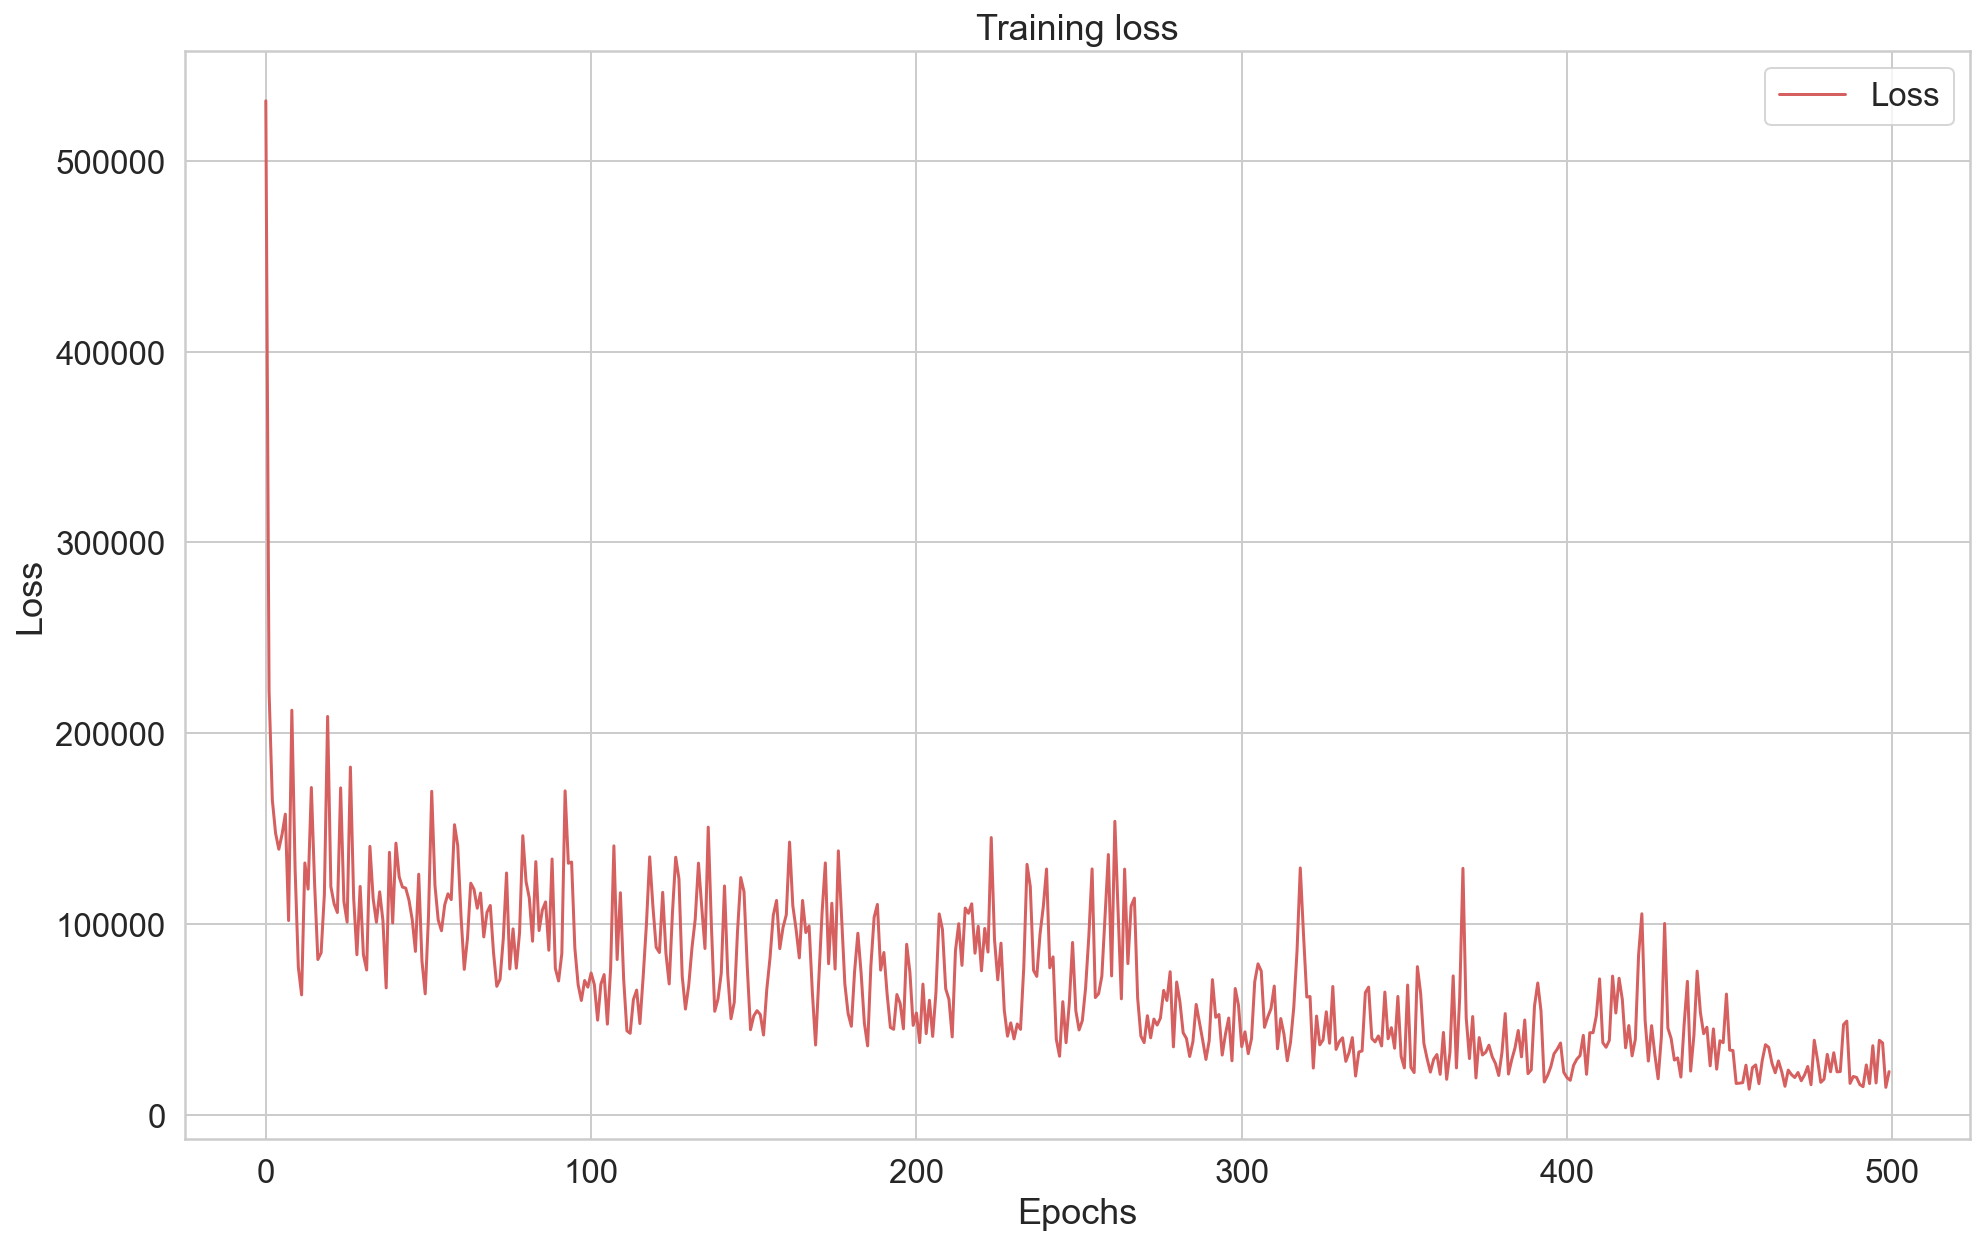

<Figure size 1152x720 with 0 Axes>

In [19]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
# ini forecast untuk RNN
rnn_forecast = model_forecast(model, series_trimmed[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

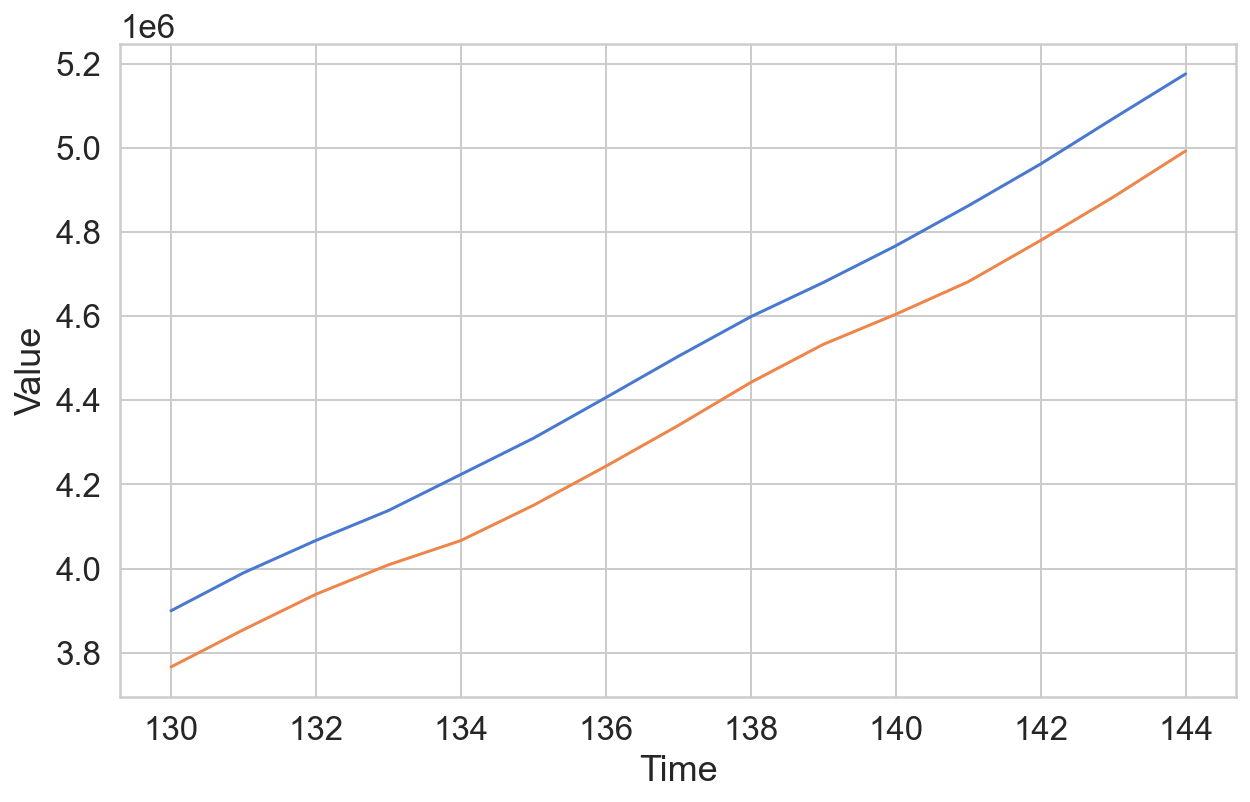

In [20]:
# ini forecast untuk yg DNN
forecast=[]
for time in range(len(series_trimmed) - window_size):
  forecast.append(model.predict(series_trimmed[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

157800.64